In [1]:
import numpy as np
from geopy.distance import great_circle, Distance
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.cluster import DBSCAN
from geopy.geocoders import Nominatim
import random
import pandas as pd
import json
import requests
from tqdm import tqdm

In [2]:
n_location = 100 # number of customer locations

# ranges of latitude and longitude
LAT_MIN, LAT_MAX = 55, 56
LON_MIN, LON_MAX = 23, 25

# type represents the type of location: 
# 0 - manufacturing souce, 1 - distrubution center, 2 - customer location
SRC_TYPE, DC_TYPE, CUSTOMER_TYPE = 'source', 'dc', 'customer'
latitudes, longitudes, weights, demands, types = [], [], [], [], []
for _ in range(n_location):
    latitudes.append(random.uniform(LAT_MIN, LAT_MAX))
    longitudes.append(random.uniform(LON_MIN, LON_MAX))
    weights.append(random.uniform(1, 5))
    demands.append(random.randint(1, 10))
    types.append(CUSTOMER_TYPE)

# total demand    
X = np.sum(demands)
    
# Create a sample dataframe
data = {
    'City': ['customer ' + str(x) for x in range(1, n_location+1)],
    'Latitude': latitudes,
    'Longitude': longitudes,
    'Weight': weights,
    'Demand': demands,
    'Type': types
}
df = pd.DataFrame(data)

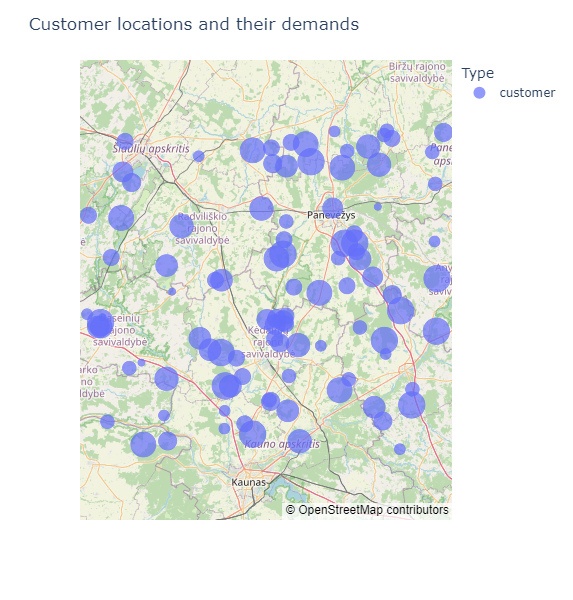

In [3]:
# Use Plotly Express to create the scatter mapbox plot
fig = px.scatter_mapbox(df, lat='Latitude', lon='Longitude', hover_name='City', size='Demand', color='Type', 
                        color_continuous_scale='Viridis', mapbox_style='carto-positron', height=600, width=1000)

# Update the layout of the figure
fig.update_layout(title='Customer locations and their demands',
                  mapbox=dict(center=dict(lat=(LAT_MIN+LAT_MAX)/2, lon=(LON_MIN+LON_MAX)/2), style='open-street-map', zoom=7))

# Show the plot
fig.show()

In [5]:
# Center of Gravity
volumes = np.array(weights) * np.array(demands)
c_lat = (np.array(latitudes) * volumes).sum() / volumes.sum()
c_lon = (np.array(longitudes) * volumes).sum() / volumes.sum()
print('Center of Gravity')
(c_lat, c_lon)

Center of Gravity


(55.51238256232724, 24.12456742756613)

In [6]:
def get_geo_dist_kms(loc1, loc2):
    return Distance(miles=great_circle(loc1, loc2).miles).km

def get_road_dist_kms(loc1, loc2):
    r = requests.get(f"""http://router.project-osrm.org/route/v1/car/{loc1[1]},{loc1[0]};{loc2[1]},{loc2[0]}?overview=false""")
    data = json.loads(r.content)
    routes = data["routes"]
    d = 0
    for route in routes:
        d += route['distance']
    return d / 1000

In [7]:
d1 = get_geo_dist_kms((c_lat, c_lon), (latitudes[0], longitudes[1]))
print(f'Distance from ({c_lat}, {c_lon}) to ({latitudes[0]}, {longitudes[1]}) is {d1} kms.')
d2 = get_road_dist_kms((c_lat, c_lon), (latitudes[0], longitudes[1]))
print(f'Road distance from ({c_lat}, {c_lon}) to ({latitudes[0]}, {longitudes[1]}) is {d2} kms.')

Distance from (55.51238256232724, 24.12456742756613) to (55.939776164479326, 24.446168518299032) is 51.61474109241203 kms.
Road distance from (55.51238256232724, 24.12456742756613) to (55.939776164479326, 24.446168518299032) is 66.9185 kms.


In [8]:
# location of manufacturing source
LAT_SRC, LON_SRC = 55.3, 24.5
loc_src = (LAT_SRC, LON_SRC)

# number of distributing centers
n_dc = 100
dc_latitudes, dc_longitudes, dc_types = [], [], []
# set a gravity center as a distribution center
dc_latitudes.append(c_lat)
dc_longitudes.append(c_lon)
dc_types.append(DC_TYPE)
for i in range(n_dc-1):
    dc_latitudes.append(random.uniform(LAT_MIN, LAT_MAX))
    dc_longitudes.append(random.uniform(LON_MIN, LON_MAX))
    dc_types.append(DC_TYPE)
    
df_dc = pd.DataFrame({
    'City': ['dc ' + str(x) for x in range(1, n_dc+1)],
    'Latitude': dc_latitudes,
    'Longitude': dc_longitudes,
    'Type': dc_types
})

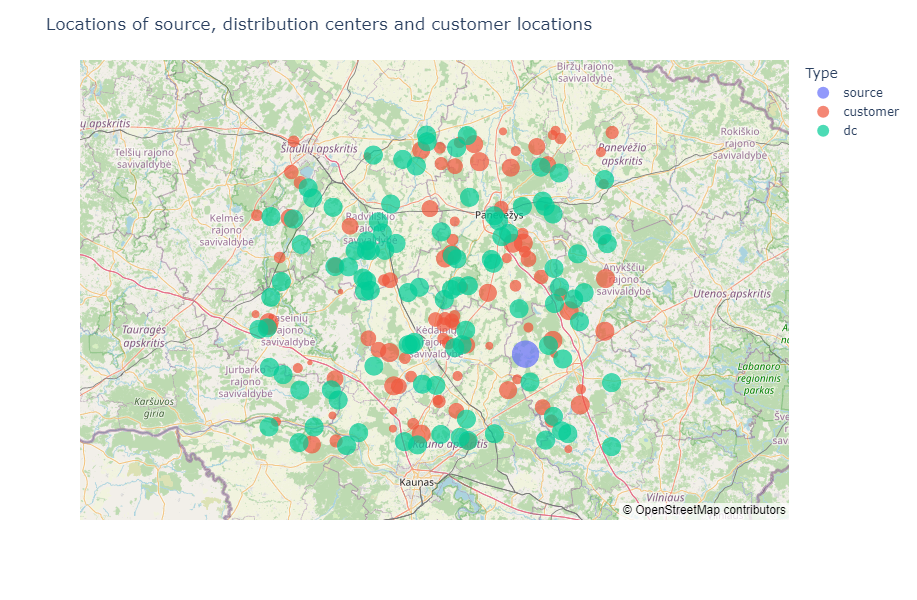

In [9]:
df_all = pd.DataFrame({
    'City': ['SOURCE'] + list(df['City']) + list(df_dc['City']),
    'Latitude': [LAT_SRC] + latitudes + dc_latitudes,
    'Longitude': [LON_SRC] + longitudes + dc_longitudes,
    'Type': [SRC_TYPE] + types + dc_types,
    'Size': [20] + demands + ([10] * n_dc)
})

# Use Plotly Express to create the scatter mapbox plot
fig = px.scatter_mapbox(df_all, lat='Latitude', lon='Longitude', hover_name='City', size='Size', color='Type', 
                        color_continuous_scale='Viridis', mapbox_style='carto-positron', height=600, width=1000)

# Update the layout of the figure
fig.update_layout(title='Locations of source, distribution centers and customer locations',
                  mapbox=dict(center=dict(lat=(LAT_MIN+LAT_MAX)/2, lon=(LON_MIN+LON_MAX)/2), style='open-street-map', zoom=7))

# Show the plot
fig.show()

In [10]:
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus, value

In [11]:
dist_func = get_geo_dist_kms
# dist_func = get_road_dist_kms
print('Calcuate distances from source to distributing centers')
l = [dist_func(loc_src, loc) for loc in tqdm(zip(dc_latitudes, dc_longitudes))]
print('Calcuate distances from distributing centers to customer locations')
d = []
for i, loc_dc in enumerate(zip(dc_latitudes, dc_longitudes)):
    print(f'distribution center no {i+1}')
    di = []
    for loc_cus in tqdm(zip(latitudes, longitudes)):
        di.append(dist_func(loc_dc, loc_cus))
    d.append(di)

Calcuate distances from source to distributing centers


100it [00:00, 50375.98it/s]


Calcuate distances from distributing centers to customer locations
distribution center no 1


100it [00:00, 49997.66it/s]


distribution center no 2


100it [00:00, 99816.85it/s]


distribution center no 3


100it [00:00, 50075.26it/s]


distribution center no 4


100it [00:00, 102801.57it/s]


distribution center no 5


100it [00:00, 49772.21it/s]


distribution center no 6


100it [00:00, 49878.75it/s]


distribution center no 7


100it [00:00, 102700.88it/s]


distribution center no 8


100it [00:00, 49985.75it/s]


distribution center no 9


100it [00:00, 50045.39it/s]


distribution center no 10


100it [00:00, 49997.66it/s]


distribution center no 11


100it [00:00, 100102.72it/s]


distribution center no 12


100it [00:00, 100198.38it/s]


distribution center no 13


100it [00:00, 101189.48it/s]


distribution center no 14


100it [00:00, 49501.99it/s]


distribution center no 15


100it [00:00, 49350.56it/s]


distribution center no 16


100it [00:00, 50033.45it/s]


distribution center no 17


100it [00:00, 100873.11it/s]


distribution center no 18


100it [00:00, 50189.11it/s]


distribution center no 19


100it [00:00, 50033.45it/s]


distribution center no 20


100it [00:00, 49950.03it/s]


distribution center no 21


100it [00:00, 99485.39it/s]


distribution center no 22


100it [00:00, 49455.30it/s]


distribution center no 23


100it [00:00, 49286.77it/s]


distribution center no 24


100it [00:00, 100318.20it/s]


distribution center no 25


100it [00:00, 100703.58it/s]


distribution center no 26


100it [00:00, 49513.68it/s]


distribution center no 27


100it [00:00, 49240.48it/s]


distribution center no 28


100it [00:00, 100462.37it/s]


distribution center no 29


100it [00:00, 97157.84it/s]


distribution center no 30


100it [00:00, 98043.57it/s]


distribution center no 31


100it [00:00, 49979.79it/s]


distribution center no 32


100it [00:00, 100007.25it/s]


distribution center no 33


100it [00:00, 102325.05it/s]


distribution center no 34


100it [00:00, 100126.62it/s]


distribution center no 35


100it [00:00, 100631.09it/s]


distribution center no 36


100it [00:00, 100222.32it/s]


distribution center no 37


100it [00:00, 49938.14it/s]


distribution center no 38


100it [00:00, 50003.62it/s]


distribution center no 39


100it [00:00, 51093.97it/s]


distribution center no 40


100it [00:00, 99485.39it/s]


distribution center no 41


100it [00:00, 99156.12it/s]


distribution center no 42


100it [00:00, 49589.78it/s]


distribution center no 43


100it [00:00, 50255.26it/s]


distribution center no 44


100it [00:00, 49257.83it/s]


distribution center no 45


100it [00:00, 99793.10it/s]


distribution center no 46


100it [00:00, 49525.37it/s]


distribution center no 47


100it [00:00, 100246.27it/s]


distribution center no 48


100it [00:00, 100246.27it/s]


distribution center no 49


100it [00:00, 100174.44it/s]


distribution center no 50


100it [00:00, 99532.61it/s]


distribution center no 51


100it [00:00, 100054.96it/s]


distribution center no 52


100it [00:00, 50021.51it/s]


distribution center no 53


100it [00:00, 101507.84it/s]


distribution center no 54


100it [00:00, 49985.75it/s]


distribution center no 55


100it [00:00, 49991.70it/s]


distribution center no 56


100it [00:00, 98250.27it/s]


distribution center no 57


100it [00:00, 49950.03it/s]


distribution center no 58


100it [00:00, 100078.84it/s]


distribution center no 59


100it [00:00, 100054.96it/s]


distribution center no 60


100it [00:00, 49961.93it/s]


distribution center no 61


100it [00:00, 49920.30it/s]


distribution center no 62


100it [00:00, 50015.55it/s]


distribution center no 63


100it [00:00, 100150.53it/s]


distribution center no 64


100it [00:00, 100007.25it/s]


distribution center no 65


100it [00:00, 103054.15it/s]


distribution center no 66


100it [00:00, 100390.23it/s]


distribution center no 67


100it [00:00, 100294.21it/s]


distribution center no 68


100it [00:00, 50147.11it/s]


distribution center no 69


100it [00:00, 99039.06it/s]


distribution center no 70


100it [00:00, 100078.84it/s]


distribution center no 71


100it [00:00, 100606.96it/s]


distribution center no 72


100it [00:00, 100873.11it/s]


distribution center no 73


100it [00:00, 96866.14it/s]


distribution center no 74


100it [00:00, 50093.20it/s]


distribution center no 75


100it [00:00, 49997.66it/s]


distribution center no 76


100it [00:00, 50231.19it/s]


distribution center no 77


100it [00:00, 50159.10it/s]


distribution center no 78


100it [00:00, 49223.14it/s]


distribution center no 79


100it [00:00, 99959.58it/s]


distribution center no 80


100it [00:00, 50606.95it/s]


distribution center no 81


100it [00:00, 99793.10it/s]


distribution center no 82


100it [00:00, 50183.11it/s]


distribution center no 83


100it [00:00, 50189.11it/s]


distribution center no 84


100it [00:00, 49866.89it/s]


distribution center no 85


100it [00:00, 99935.76it/s]


distribution center no 86


100it [00:00, 100582.83it/s]


distribution center no 87


100it [00:00, 101116.30it/s]


distribution center no 88


100it [00:00, 101852.94it/s]


distribution center no 89


100it [00:00, 50345.74it/s]


distribution center no 90


100it [00:00, 50135.12it/s]


distribution center no 91


100it [00:00, 50045.39it/s]


distribution center no 92


100it [00:00, 49760.40it/s]


distribution center no 93


100it [00:00, 100703.58it/s]


distribution center no 94


100it [00:00, 99983.41it/s]


distribution center no 95


100it [00:00, 100270.24it/s]


distribution center no 96


100it [00:00, 50267.31it/s]


distribution center no 97


100it [00:00, 50093.20it/s]


distribution center no 98


100it [00:00, 50515.52it/s]


distribution center no 99


100it [00:00, 49997.66it/s]


distribution center no 100


100it [00:00, 99911.96it/s]


In [12]:
# Mathematical Modeling using linear optimization
prob = LpProblem('Supply Chain', LpMinimize)

# Define the decision variables
# number of products from source to dcs
x = LpVariable.dicts('x', range(n_dc), lowBound=0, upBound=X, cat='Int')
# number of products from dcs to customer locations
y = [LpVariable.dicts('y_' + str(j), range(n_location), lowBound=0, upBound=X, cat='Int') for j in range(n_dc)]
# flags for use of dcs
b = LpVariable.dicts('b', range(n_dc), lowBound=0, upBound=1, cat='Binary')

# Define the objective function
prob += lpSum([(l[j] * x[j] + lpSum([(weights[k] * d[j][k]) * y[j][k] for k in range(n_location)])) for j in range(n_dc)])

# Define the constraints
for j in range(n_dc):
    prob += x[j] - lpSum([y[j][k] for k in range(n_location)]) == 0
for k in range(n_location):
    prob += lpSum([y[j][k] for j in range(n_dc)]) == demands[k]
for j in range(n_dc):
    prob += x[j] <= b[j] * X
prob += lpSum([b[j] for j in range(n_dc)]) == 3

# Solve the LP problem
prob.solve()

C:\Users\pc\anaconda3\lib\site-packages\pulp\pulp.py:1352: UserWarning:

Spaces are not permitted in the name. Converted to '_'



1

In [13]:
# Print the status of the solution
print("Status:", LpStatus[prob.status])
print("Total: ", X)
x = np.zeros(n_dc)
y = np.zeros((n_dc, n_location))
b = np.zeros(n_dc)
print("Optimal Solution:")
for v in prob.variables():
    items = v.name.split('_')
    if items[0] == 'x':
        x[int(items[1])] = v.varValue
    elif items[0] == 'b':
        b[int(items[1])] = v.varValue
    else:
        y[int(items[1])][int(items[2])] = v.varValue
selected_ids = [b[i] > 0.5 for i in range(n_dc)]
selected_supplies = x[selected_ids]
for i, s in zip(selected_ids, selected_supplies):
    print(f'dc {i}: ', s)
# Print the optimal value of the objective function
print("Optimal Objective Value =", value(prob.objective))

Status: Optimal
Total:  554
Optimal Solution:
dc False:  149.0
dc False:  231.0
dc False:  174.0
Optimal Objective Value = 61572.862009410805


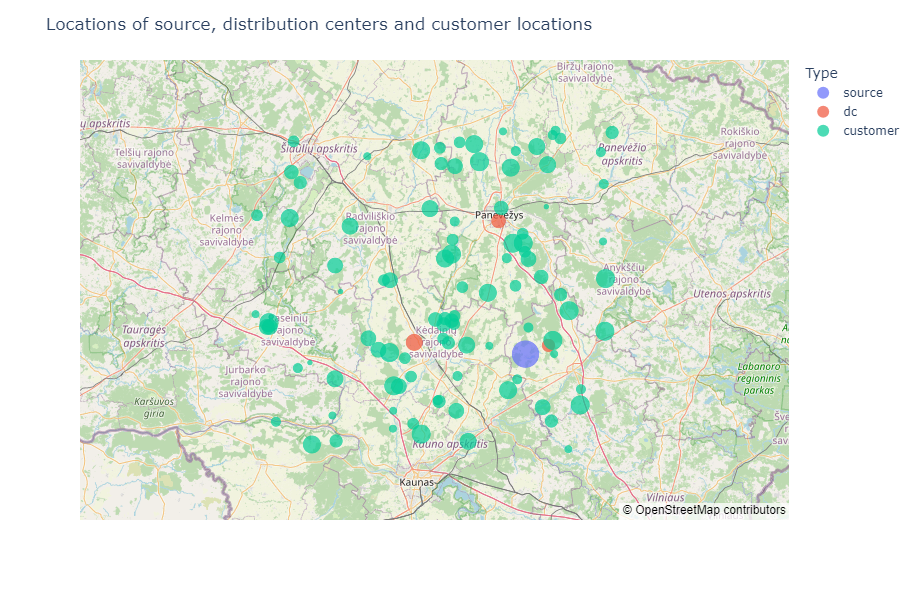

In [14]:
df_all = pd.DataFrame({
    'City': ['SOURCE'] + list(df_dc['City'][selected_ids]) + list(df['City']),
    'Latitude': [LAT_SRC] + list(np.array(dc_latitudes)[selected_ids]) + latitudes,
    'Longitude': [LON_SRC] + list(np.array(dc_longitudes)[selected_ids]) + longitudes,
    'Type': [SRC_TYPE] + list(np.array(dc_types)[selected_ids]) + types,
    'Size': [20] + list(selected_supplies * 20 // X) + demands 
})

# Use Plotly Express to create the scatter mapbox plot
fig = px.scatter_mapbox(df_all, lat='Latitude', lon='Longitude', hover_name='City', size='Size', color='Type', 
                        color_continuous_scale='Viridis', mapbox_style='carto-positron', height=600, width=1000)

# Update the layout of the figure
fig.update_layout(title='Locations of source, distribution centers and customer locations',
                  mapbox=dict(center=dict(lat=(LAT_MIN+LAT_MAX)/2, lon=(LON_MIN+LON_MAX)/2), style='open-street-map', zoom=7))

# Show the plot
fig.show()